In [1]:
# Import necessary modules, libraries, etc. 
import re # For regular expressions 
import os #
import pathlib # 
import time # For generating runtime
import numpy as np # For linear algebra
import pandas as pd # For processing data
import matplotlib
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
import tensorflow as tf # For deep machine learning models
from tensorflow import keras # For deep machine learning models
import keras_tuner as kt # For tuning neural network hyperparameters  
from keras.models import Sequential # For buidling NN model
from keras.layers import Dense, Conv1D, MaxPooling1D # For building NN model
from keras.layers import LSTM, Dropout # For building NN model
from keras.layers import Embedding, TextVectorization # For building NN model and vectorizing text
from keras.preprocessing import sequence
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import nltk # for natural language processing
from nltk.corpus import stopwords # for removing english stopwords
from nltk.stem import WordNetLemmatizer # for term stemming
from prettytable import PrettyTable # For data visualization
import sklearn # for predictive data analysis
from sklearn.model_selection import train_test_split # Split data into train and test sets
from tabulate import tabulate # for converting lists/dictionaries into nice tables
from IPython.core.interactiveshell import InteractiveShell # to modify Jupyter notebook configuration
InteractiveShell.ast_node_interactivity = "all" # so that all outputs in a cell are returned (instead of last instance)

In [2]:
# Load the fake and true news CSVs into Pandas dataframes
true_news = pd.read_csv('True.csv') 
fake_news = pd.read_csv('Fake.csv')

# Add column for fake/true target (true == 1, false == 0)
true_news['target'] = 1
fake_news['target'] = 0

# True and Fake news value counts - are they balanced?
print("Compare number of observations in true news and fake news data frames")
true_news['target'].value_counts()
print()
fake_news['target'].value_counts()
print()

Compare number of observations in true news and fake news data frames


1    21417
Name: target, dtype: int64

0    23481
Name: target, dtype: int64

In [3]:
# Remove random rows from fake_news (n = 2064) data frame so it has same number of rows as true_news
np.random.seed(5)
remove_n = 2064
drop_indices = np.random.choice(fake_news.index, remove_n, replace = False)
fake_news = fake_news.drop(drop_indices)

# Check that have same number of observations now
print("True and fake datasets should have same number of samples now...")
true_news['target'].value_counts()
print()
fake_news['target'].value_counts()
print()

# Preview first and last 5 rows in datasets to ensure they imported properly
print("Preview of the raw datasets to ensure they imported properly:")
true_news.head(-5)
print()
fake_news.head(-5)
print()

True and fake datasets should have same number of samples now...


1    21417
Name: target, dtype: int64

0    21417
Name: target, dtype: int64


Preview of the raw datasets to ensure they imported properly:


,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1
...,...,...,...,...,...
21407,"Mata Pires, owner of embattled Brazil builder ...","SAO PAULO (Reuters) - Cesar Mata Pires, the ow...",worldnews,"August 22, 2017",1
21408,"U.S., North Korea clash at U.N. forum over nuc...",GENEVA (Reuters) - North Korea and the United ...,worldnews,"August 22, 2017",1
21409,"U.S., North Korea clash at U.N. arms forum on ...",GENEVA (Reuters) - North Korea and the United ...,worldnews,"August 22, 2017",1
21410,Headless torso could belong to submarine journ...,COPENHAGEN (Reuters) - Danish police said on T...,worldnews,"August 22, 2017",1


,title,text,subject,date,target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0
...,...,...,...,...,...
23471,Seven Iranians freed in the prisoner swap have...,"21st Century Wire says This week, the historic...",Middle-east,"January 20, 2016",0
23472,#Hashtag Hell & The Fake Left,By Dady Chery and Gilbert MercierAll writers ...,Middle-east,"January 19, 2016",0
23473,Astroturfing: Journalist Reveals Brainwashing ...,Vic Bishop Waking TimesOur reality is carefull...,Middle-east,"January 19, 2016",0
23474,The New American Century: An Era of Fraud,Paul Craig RobertsIn the last years of the 20t...,Middle-east,"January 19, 2016",0


In [4]:
# Combine true_news and fake_news data frames into one
dfs = [true_news, fake_news]
news_data = pd.concat(dfs)

# Concatenate text columns and isolate only relevant columns for analysis (i.e., text and target)
news_data['text'] = news_data['title'] + ' ' + news_data['text']
news_data = news_data[['text', 'target']]

# Check that binary values were assigned correctly
print("Dimensions of data frame that will be cleaned:")
news_data.shape # data frame dimensions
print()

print("First and last five rows of pre-cleaned concatenated dataset:")
news_data.head(-5) # first 5 and last 5 rows
print()

print("Null values by column:")
news_data.isnull().sum() # check for null values
print()

Dimensions of data frame that will be cleaned:


(42834, 2)


First and last five rows of pre-cleaned concatenated dataset:


,text,target
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1
...,...,...
23471,Seven Iranians freed in the prisoner swap have...,0
23472,#Hashtag Hell & The Fake Left By Dady Chery a...,0
23473,Astroturfing: Journalist Reveals Brainwashing ...,0
23474,The New American Century: An Era of Fraud Paul...,0



Null values by column:


text      0
target    0
dtype: int64

In [5]:
# Instantiate WordNetLemmatizer() -- reduce words to their roots
wnl = WordNetLemmatizer()

# Download multilingual Wordnet data from OMW
nltk.download('omw-1.4')

# List of english stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Download english dictionary ('wordnet')
nltk.download('wordnet');

# Download pre-trained GloVe embeddings using the following commands: 
# "wget http://nlp.stanford.edu/data/glove.6B.zip"
# "unzip -q glove.6B.zip"

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ZLoken\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ZLoken\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ZLoken\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
# Function for cleaning/preprocessing data
def data_cleaning(row):
    row = row.lower() # convert text into lowercase
    row = re.sub('[^a-zA-Z]', ' ', row) # remove number and special characters using regex (keep letters only)
    token = row.split() # split the data into tokens
    news = [wnl.lemmatize(word) for word in token if not word in stop_words] # lemmatize the words and remove any stopwords (e.g., a, an, the, etc.)
    row_clean = [word for word in news if len(word) >= 3] # only keep words greater than or equal to length of 3
    cleaned_news = ' '.join(row_clean) # join all tokenized words with space in between 
    
    return cleaned_news

In [7]:
# Clean the data - might take a couple minutes to run.
news_data['text'] = news_data['text'].apply(lambda x : data_cleaning(x)) # 'text' column gets cleaned
print("First and last five rows after cleaning the data:")
news_data.head(-5) # check that cleaning went as planned
print()

First and last five rows after cleaning the data:


,text,target
0,budget fight loom republican flip fiscal scrip...,1
1,military accept transgender recruit monday pen...,1
2,senior republican senator let mueller job wash...,1
3,fbi russia probe helped australian diplomat ti...,1
4,trump want postal service charge much amazon s...,1
...,...,...
23471,seven iranian freed prisoner swap returned ira...,0
23472,hashtag hell fake left dady chery gilbert merc...,0
23473,astroturfing journalist reveals brainwashing t...,0
23474,new american century era fraud paul craig robe...,0


In [8]:
# Check for null values
print("Null values by column:")
news_data.isnull().sum() # want zero null values
print()

# Check number unique values in each column
print("Unique values by column:")
news_data.nunique() # number unique values in each column
print()

Null values by column:


text      0
target    0
dtype: int64


Unique values by column:


text      37681
target        2
dtype: int64

In [9]:
# Randomly shuffle rows in news_data
news_data = news_data.sample(frac = 1)
print("First and last five rows after shuffling the data:")
news_data.head(-5) # check that shuffling went as planned
print()

First and last five rows after shuffling the data:


,text,target
15906,russia putin say situation syria developing po...,1
9518,boston men jailed trump inspired hate crime at...,1
20530,watch child molester bernie sander want voter ...,0
15577,mattis back geneva process syrian conflict hel...,1
15769,death toll strike gaza tunnel week rise gaza r...,1
...,...,...
20840,czech lawmaker vote force candidate babis face...,1
12369,crybaby community organizer make fool germany ...,0
11366,turkey restore sudanese red sea port build nav...,1
19048,turnout high iraqi kurd defy threat hold indep...,1


In [10]:
# Isolate the target and text features
target = news_data['target'] # target values
text_dataset = news_data['text'] # predictor text features

# Check first and last 5 rows of target and text datasets
target.head(-5)
text_dataset.head(-5)

15906    1
9518     1
20530    0
15577    1
15769    1
        ..
20840    1
12369    0
11366    1
19048    1
1068     0
Name: target, Length: 42829, dtype: int64

15906    russia putin say situation syria developing po...
9518     boston men jailed trump inspired hate crime at...
20530    watch child molester bernie sander want voter ...
15577    mattis back geneva process syrian conflict hel...
15769    death toll strike gaza tunnel week rise gaza r...
                               ...                        
20840    czech lawmaker vote force candidate babis face...
12369    crybaby community organizer make fool germany ...
11366    turkey restore sudanese red sea port build nav...
19048    turnout high iraqi kurd defy threat hold indep...
1068     trying brag trump accidentally showed sexist r...
Name: text, Length: 42829, dtype: object

In [11]:
# Split the data into training and test subsets
train_data, test_data, train_target, test_target = train_test_split(text_dataset, target, random_state = 5, train_size = 0.80)

# Check the split from into training and testing datasets
train_data.head(-5)
test_target.head(-5)

14637    french military say coalition opposed withdraw...
17168    britain say chance resolving northern ireland ...
17485    president trump blast retiring fbi deputy dire...
13169    blacklivesmatter golf take priority vet old ve...
22560    boiler room lord pedo ring political correct h...
                               ...                        
15584    video american vet fighting isi sit back watch...
6267     think trump want keep job home think profiting...
0        budget fight loom republican flip fiscal scrip...
3045     white house say trump tweet meet comey tape re...
1198     watch watergate reporter carl bernstein hammer...
Name: text, Length: 34262, dtype: object

14914    0
14192    1
607      1
16390    0
14475    0
        ..
20560    0
12861    0
21035    0
2398     1
13396    0
Name: target, Length: 8562, dtype: int64

In [12]:
# Convert the text_dataset, train_data, and test_data text data frames to a tensor
train_data = tf.convert_to_tensor(train_data, dtype = tf.string) # for training the model
test_data = tf.convert_to_tensor(test_data, dtype = tf.string) # for testing the model
train_target = tf.convert_to_tensor(train_target, dtype = tf.int32) # train data
test_target = tf.convert_to_tensor(test_target, dtype = tf.int32) # test data
text_dataset = tf.convert_to_tensor(text_dataset, dtype = tf.string) # for mapping text to vectors using gloVe pre-trained word embeddings

# Double check conversion to tensor slices
test_data
train_target

<tf.Tensor: shape=(8567,), dtype=string, numpy=
array([b'hillary barack choose islam christianity every time always brilliant ben shapiro answer question well brilliant way tuesday former secretary state hillary clinton american woman responsible current refugee crisis middle east blasted republican wanting accept unvetted syrian muslim refugee aftermath last week paris terror attack tweeted seen lot hateful rhetoric gop idea turn away refugee religion new low hillary clinton hillaryclinton november sure odd hillary decrying hateful rhetoric smack irony despises republican much labeled enemy first demoratic debate furthermore hillary fighter religious freedom april told woman world summit deep seated cultural code religious belief structural bias changed allow abortion aftermath supreme court egregious sex marriage decision june hillary explicitly called government force church sanction homosexuality explaining work finished every american marry live work pray learn raise family free d

<tf.Tensor: shape=(34267,), dtype=int32, numpy=array([1, 1, 0, ..., 1, 0, 0])>

In [13]:
# List of different values to try for TfidVectorizer max_features (i.e., top key words)
key_words = 200 # How many of the top key words to keep - iterate over list
n_grams = (1, 2) # ngram_range dictates if we keep 1 word (1, 1), 1 or 2 words (1, 2) etc.
max_len = 300 # sequence length to pad the outputs to

In [14]:
# Create the vocabulary index. 
vectorizer = tf.keras.layers.TextVectorization(
    max_tokens = key_words, # number of top key words to keep
    standardize = None, # data already cleaned above
    split = 'whitespace', # already split tokens during data cleaning
    ngrams = n_grams, # range of token string lengths to keep in max_tokens (unigram, bigram, trigram)
    output_mode = 'int', # outputs one integer index per split string token
    output_sequence_length = max_len, # if set, output will have its time (length) dimension padded to exactly the specified value
    pad_to_max_tokens = False, # not valid argument for integer outputs
    vocabulary = None, # optional, the adapt layer below handle's this step better
    idf_weights = None, # not valid argument for integer outputs
    sparse = False, # not applicable argument for integer outputs
    ragged = False, # false cause you want each sequence shrunk or padded to the same output_sequence_length
)

In [15]:
# Now that the vocab layer has been created, call `adapt` on the text-only
# dataset to create the vocabulary. You don't have to batch, but for large
# datasets this means we're not keeping spare copies of the dataset.
vectorizer.adapt(text_dataset) # vocabulary is truncated to max_tokens (number key words) during adapt()

In [16]:
# Retrieve the top 10 words from vectorized vocabulary
vectorizer.get_vocabulary()[:10]

['',
 '[UNK]',
 'trump',
 'said',
 'state',
 'president',
 'would',
 'year',
 'people',
 'republican']

In [17]:
# Create a dictionary mapping words to their indices
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [18]:
# Make a dictionary mapping strings to their NumPy vector representation in gloVe:
data_dir = 'E:/Zack/School/Classes/Summer 22/CSC 7333 - Machine Learning/Group Project/glove.6B.100d.txt'

embeddings_index = {}
with open(data_dir, encoding = "utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit = 1)
        coefs = np.fromstring(coefs, "f", sep = " ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [19]:
# Define arguments for a corresponding embedding matrix to use in the model's Embedding layer
num_tokens = len(voc) + 2 # plus 2 because 0 is reserved for padding and 1 is reserved for tokens not in vocab
embedding_dim = 100
hits = 0
misses = 0

In [20]:
# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 193 words (7 misses)


In [21]:
# Create the model that uses the vectorized text layer
model = Sequential()

In [22]:
# Start by creating an explicit input layer. It needs to have a shape of
# (1,) (because we need to guarantee that there is exactly one string
# input per batch), and the dtype needs to be 'string'.
model.add(tf.keras.Input(shape = (1,), dtype = tf.string))

In [23]:
# The first layer in our model is the vectorization layer. After this layer,
# we have a tensor of shape (batch_size, max_len) containing vocab indices
model.add(vectorizer)

In [25]:
# Now, the model can map strings to integers, and you can add an embedding
# layer to map these integers to learned embeddings.
model.add(Embedding(
    num_tokens, # kw (or voc) + 2
    embedding_dim, # 100 dimension matrix
    input_length = max_len, # size of the padded sequence
    embeddings_initializer = keras.initializers.Constant(embedding_matrix), # intialize based on your embedding matrix
    trainable = False # set to false so you don't update embedding during training
))

In [26]:
# Add the convolutional layer
model.add(Conv1D(filters = 128, kernel_size = 5, padding = 'same', activation = 'relu')) # extract local features using 128 filters with kernel size of 5 and default ReLU activiation function

In [27]:
# Add the pooling layer
model.add(MaxPooling1D(pool_size = 2)) # pool large vector features from above CNN layer with window size of 2--this downsamples the feature vectors/parameters

In [28]:
# Add the RNN (LSTM) layer
model.add(LSTM(32)) # this is your RNN (long short-term memory (LSTM)) layer; the pooled features from above layer are the input w/ default hyperbolic tangent activation

In [29]:
# Add the dense layer for classifying outputs
model.add(Dense(1, activation = 'sigmoid')) # this layer classifies the trained vector features and shrinks the output dimension to 1, which corresponds to classification label. 

In [30]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy']) # configure the model for training

In [31]:
# CNN-RNN hybrid model structure: 
print(f"CNN-RNN hybrid model structure using top {key_words} words and an n-gram range of {n_grams} is:") 
print(model.summary())
print()

CNN-RNN hybrid model structure using top 200 words and an n-gram range of (1, 2) is:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 300)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 300, 100)          20200     
                                                                 
 conv1d_1 (Conv1D)           (None, 300, 128)          64128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 150, 128)         0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 32)                20608     
                                     

In [33]:
# Save model weights while fitting baseline model on training data
filepath = "baseline_weights_cnn-rnn.tf"
checkpoint = ModelCheckpoint(filepath, monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'max', save_weights_only = True)
callbacks_list = [checkpoint]
history = model.fit(train_data, train_target, epochs = 5, batch_size = 64, verbose = 1, callbacks = callbacks_list, validation_data = (test_data, test_target)) # train the model using batch size 64 across 10 epochs using adaptive moment estimation (ADAM) to define learning rate in each epoch

Epoch 1/5
536/536 [==============================] - ETA: 0s - loss: 0.4463 - accuracy: 0.8063
Epoch 1: val_accuracy improved from -inf to 0.75791, saving model to baseline_weights_cnn-rnn.tf
536/536 [==============================] - 62s 113ms/step - loss: 0.4463 - accuracy: 0.8063 - val_loss: 0.5100 - val_accuracy: 0.7579
Epoch 2/5
536/536 [==============================] - ETA: 0s - loss: 0.4214 - accuracy: 0.8134
Epoch 2: val_accuracy improved from 0.75791 to 0.93405, saving model to baseline_weights_cnn-rnn.tf
536/536 [==============================] - 71s 132ms/step - loss: 0.4214 - accuracy: 0.8134 - val_loss: 0.2247 - val_accuracy: 0.9340
Epoch 3/5
536/536 [==============================] - ETA: 0s - loss: 0.4162 - accuracy: 0.8214
Epoch 3: val_accuracy did not improve from 0.93405
536/536 [==============================] - 71s 132ms/step - loss: 0.4162 - accuracy: 0.8214 - val_loss: 0.6336 - val_accuracy: 0.6516
Epoch 4/5
536/536 [==============================] - ETA: 0s - lo

In [34]:
# Evaluate the baseline model
scores = model.evaluate(test_data, test_target, verbose = 0)
accuracy = (scores[1]*100)
loss = (scores[0])
print(f"CNN-RNN hybrid model accuracy using top {key_words} words, an n-gram range of {n_grams},\nand padded length {max_len} is: {accuracy:.2f}%")

CNN-RNN hybrid model accuracy using top 200 words, an n-gram range of (1, 2),
and padded length 300 is: 99.51%


In [35]:
modelMetrics = {'n_grams': [], 'key_words': [], 'padded_length': [], 'loss': [], 'accuracy': []}
modelMetrics['n_grams'].append(n_grams)
modelMetrics['key_words'].append(key_words)
modelMetrics['padded_length'].append(max_len)
modelMetrics['loss'].append(loss)
modelMetrics['accuracy'].append(accuracy)

print(tabulate(modelMetrics, headers = 'keys'))
print()

n_grams      key_words    padded_length       loss    accuracy
---------  -----------  ---------------  ---------  ----------
(1, 2)             200              300  0.0274859     99.5097



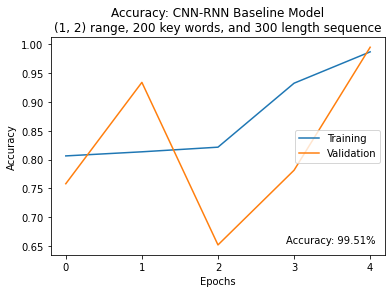

In [64]:
# Training and validation accuracy - baseline model
fig, ax = plt.subplots()
plt.plot(history.history['accuracy']) # training accuracy
plt.plot(history.history['val_accuracy']) # validation accuracy
plt.title(f'Accuracy: CNN-RNN Baseline Model\n{n_grams} range, {key_words} key words, and {max_len} length sequence')
plt.legend(['Training', 'Validation'], loc = 'center right')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.xticks([0, 1, 2, 3, 4])
# Create text box of accuracy to add to plot
text_box = AnchoredText(f"Accuracy: {accuracy:.2f}%", frameon = False, loc = 'lower right', pad = 0.5)
plt.setp(text_box.patch, facecolor = 'white', alpha = 0.5)
ax.add_artist(text_box)
plt.show();

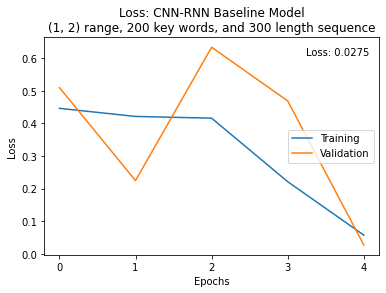

In [65]:
# Training and validation loss - baseline model
fig, ax = plt.subplots()
plt.plot(history.history['loss']) # training accuracy
plt.plot(history.history['val_loss']) # validation accuracy
plt.title(f'Loss: CNN-RNN Baseline Model\n{n_grams} range, {key_words} key words, and {max_len} length sequence') 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.xticks([0, 1, 2, 3, 4])
plt.legend(['Training', 'Validation'], loc = 'center right')
# Create text box of loss to add to plot
text_box = AnchoredText(f"Loss: {loss:.4f}", frameon = False, loc = 'upper right', pad = 0.5)
plt.setp(text_box.patch, facecolor = 'white', alpha = 0.5)
ax.add_artist(text_box)
plt.show();

In [40]:
# Hypertuning baseline model structure
def build_model(hp):
    model = Sequential()

    model.add(tf.keras.Input(shape = (1,), dtype = tf.string))
    
    model.add(vectorizer)
    
    model.add(Embedding(
        num_tokens, # kw (or voc) + 2
        embedding_dim, # 100 dimension matrix
        input_length = max_len, # size of the padded sequence
        embeddings_initializer = keras.initializers.Constant(embedding_matrix), # intialize based on your embedding matrix
        trainable = False # set to false so you don't update embedding during training
    ))
    
    model.add(Conv1D(
        hp.Choice('filters', [64, 128, 256]),
        hp.Choice('kernel_size', [3, 4, 5]),
        strides = 1, 
        activation = 'relu',
        padding = 'same'
        ))
    
    model.add(MaxPooling1D(hp.Choice('pool_size', [2, 4])))
    
    model.add(LSTM(
        hp.Choice('units', [16, 32, 64])
    ))
    
    model.add(Dense(1, 
        hp.Choice('activation', ['sigmoid', 'relu', 'linear'])
    ))
    
    model.compile(
        optimizer = Adam(hp.Choice('learning_rate', [5e-1, 1e-1, 1e-2, 1e-3, 1e-4])),
        loss = 'binary_crossentropy', 
        metrics = ['accuracy']
    )
    
    return model


In [45]:
# Initialize RandomSearch tuner for hyperparameter fine-tuning
tuner = kt.RandomSearch(
    build_model,
    overwrite = True,
    objective = 'val_accuracy', # metric to select best models by
    max_trials = 15,  # number of different models to try
    directory = 'group project'
    )

In [46]:
# Start the search and get the best model
tuner.search(train_data, train_target, epochs = 5, validation_data = (test_data, test_target))
tuner.get_best_models()[0]

Trial 15 Complete [00h 06m 44s]
val_accuracy: 0.9372009038925171

Best val_accuracy So Far: 0.9974319934844971
Total elapsed time: 01h 44m 31s
INFO:tensorflow:Oracle triggered exit


In [47]:
# Store optimal hyperparameter values
best_hp = tuner.get_best_hyperparameters()[0]

In [48]:
# Build the model with the optimal hyperparameters
optimal_model = tuner.hypermodel.build(best_hp)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 300)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 300, 100)          20200     
                                                                 
 conv1d_1 (Conv1D)           (None, 300, 128)          64128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 150, 128)         0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 32)                20608     
                                                                 
 dense (Dense)               (None, 1)                 3

In [49]:
# Save model weights while fitting baseline model on training data
filepath = "hypertuned_weights_cnn-rnn.tf"
checkpoint = ModelCheckpoint(filepath, monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'max', save_weights_only = True)
callbacks_list = [checkpoint]

In [50]:
# Fit the optimized model on training data
optimal_history = model.fit(train_data, 
    train_target, 
    epochs = 10, 
    batch_size = 64, 
    verbose = 1, 
    callbacks = callbacks_list, 
    validation_data = (test_data, test_target)
)

Epoch 1/10
536/536 [==============================] - ETA: 0s - loss: 0.0241 - accuracy: 0.9957
Epoch 1: val_accuracy improved from -inf to 0.99615, saving model to hypertuned_weights_cnn-rnn.tf
536/536 [==============================] - 63s 117ms/step - loss: 0.0241 - accuracy: 0.9957 - val_loss: 0.0218 - val_accuracy: 0.9961
Epoch 2/10
536/536 [==============================] - ETA: 0s - loss: 0.0215 - accuracy: 0.9961
Epoch 2: val_accuracy did not improve from 0.99615
536/536 [==============================] - 66s 123ms/step - loss: 0.0215 - accuracy: 0.9961 - val_loss: 0.0228 - val_accuracy: 0.9960
Epoch 3/10
536/536 [==============================] - ETA: 0s - loss: 0.0199 - accuracy: 0.9966
Epoch 3: val_accuracy did not improve from 0.99615
536/536 [==============================] - 67s 124ms/step - loss: 0.0199 - accuracy: 0.9966 - val_loss: 0.0326 - val_accuracy: 0.9936
Epoch 4/10
536/536 [==============================] - ETA: 0s - loss: 0.0167 - accuracy: 0.9969
Epoch 4: val_

In [51]:
# Evaluate the optimized model 
optimal_scores = model.evaluate(test_data, test_target, verbose = 0)
optimal_accuracy = (optimal_scores[1]*100)
optimal_loss = (optimal_scores[0])
print(f"CNN-RNN hybrid hyptertuned model accuracy using top {key_words} words, an n-gram range of {n_grams},\nand padded length {max_len} is: {optimal_accuracy:.2f}%")

CNN-RNN hybrid hyptertuned model accuracy using top 200 words, an n-gram range of (1, 2),
and padded length 300 is: 99.85%


In [63]:
# Compare hyptertuning summaries for best 2 trials. 
tuner.results_summary(2)

Results summary
Results in group project\untitled_project
Showing 2 best trials
Trial summary
Hyperparameters:
filters: 256
kernel_size: 3
pool_size: 2
units: 64
activation: sigmoid
learning_rate: 0.001
Score: 0.9974319934844971
Trial summary
Hyperparameters:
filters: 64
kernel_size: 5
pool_size: 4
units: 64
activation: linear
learning_rate: 0.01
Score: 0.996498167514801


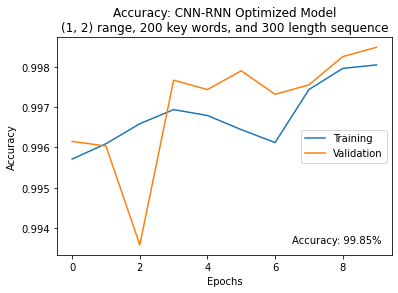

In [66]:
# Training and validation accuracy - optimized model
fig, ax = plt.subplots()
plt.plot(optimal_history.history['accuracy']) # training accuracy
plt.plot(optimal_history.history['val_accuracy']) # validation accuracy
plt.title(f'Accuracy: CNN-RNN Optimized Model\n{n_grams} range, {key_words} key words, and {max_len} length sequence')
plt.legend(['Training', 'Validation'], loc = 'center right')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.xticks([0, 2, 4, 6, 8])
# Create text box of accuracy to add to plot
text_box = AnchoredText(f"Accuracy: {optimal_accuracy:.2f}%", frameon = False, loc = 'lower right', pad = 0.5)
plt.setp(text_box.patch, facecolor = 'white', alpha = 0.5)
ax.add_artist(text_box)
plt.show();

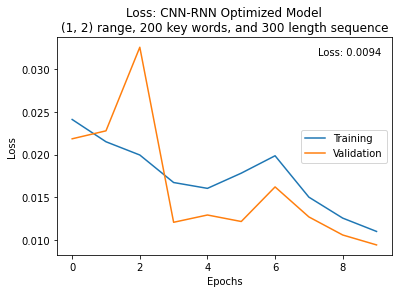

In [67]:
# Training and validation loss - optimized model
fig, ax = plt.subplots()
plt.plot(optimal_history.history['loss']) # training accuracy
plt.plot(optimal_history.history['val_loss']) # validation accuracy
plt.title(f'Loss: CNN-RNN Optimized Model\n{n_grams} range, {key_words} key words, and {max_len} length sequence') 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.xticks([0, 2, 4, 6, 8])
plt.legend(['Training', 'Validation'], loc = 'center right')
# Create text box of loss to add to plot
text_box = AnchoredText(f"Loss: {optimal_loss:.4f}", frameon = False, loc = 'upper right', pad = 0.5)
plt.setp(text_box.patch, facecolor = 'white', alpha = 0.5)
ax.add_artist(text_box)
plt.show();